In [1]:
import tensorflow as tf

In [2]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-nncl5llx
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-nncl5llx
  Resolved https://github.com/tensorflow/docs to commit 6680535155460f7eb0d2d615b9749a0cf721d4ec
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.5.3.31743-py3-none-any.whl size=182531 sha256=1d23021e48762a0b633131e2e04dd40a70cc9d92e5bf441bb8ed93479587bdfe
  Stored in directory: /tmp/pip-ephem-wheel-cache-av235b35/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [3]:
import glob
import imageio

import matplotlib.pyplot as plt
import numpy as np

import os
import PIL

from tensorflow.keras import layers

import time

from IPython import display

In [4]:
(train_imgs, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [5]:
train_imgs = train_imgs.reshape(train_imgs.shape[0], 28, 28, 1).astype('float32')
train_imgs = (train_imgs - 127.5) / 127.5  # normalize to [-1, 1]

In [6]:
BUFFER_SZ = 60_000
BATCH_SZ = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_imgs).shuffle(BUFFER_SZ).batch(BATCH_SZ)

In [7]:
def make_generator():
  model = tf.keras.Sequential()

  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100, )))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  # (batch size, same shape cuz same padding, num filters)
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  # 7x7 -> 14x14 cuz same padding + double stride (2, 2)
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                                   activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

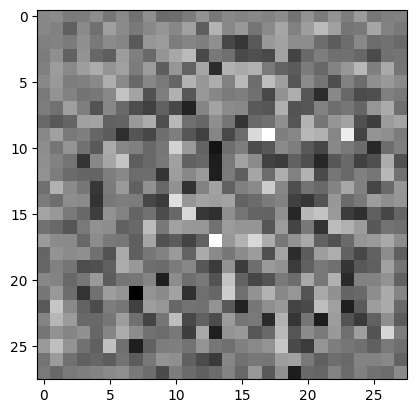

In [8]:
generator = make_generator()

noise = tf.random.normal([1, 100])
generated = generator(noise, training=False)

plt.imshow(generated[0, :, :, 0], cmap='gray')

In [9]:
def make_discriminator():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                          input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [10]:
discriminator = make_discriminator()

decision = discriminator(generated)
print(decision)

tf.Tensor([[-0.00110828]], shape=(1, 1), dtype=float32)


In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(real, fake):
  # should output all 1s when input is real
  real_loss = cross_entropy(tf.ones_like(real), real)
  # should output all 0s when input is fake
  fake_loss = cross_entropy(tf.zeros_like(fake), fake)

  total = real_loss + fake_loss
  return total

In [13]:
def generator_loss(fake):
  # generator should trick the discriminator
  # => discriminator should output 1s (say it's real)
  return cross_entropy(tf.ones_like(fake), fake)

In [14]:
generator_optim = tf.keras.optimizers.Adam(1e-4)
discriminator_optim = tf.keras.optimizers.Adam(1e-4)

In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optim=generator_optim,
    discriminator_optim=discriminator_optim,
    generator=generator,
    discriminator=discriminator
)

In [16]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# will reuse this seed so it's easier to visualize progress in the GIF
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [17]:
@tf.function
def train_step(imgs):
  noise = tf.random.normal([BATCH_SZ, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_imgs = generator(noise, training=True)

    real_out = discriminator(imgs, training=True)
    fake_out = discriminator(generated_imgs, training=True)

    gen_loss = generator_loss(fake_out)
    disc_loss = discriminator_loss(real_out, fake_out)

  gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
  disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optim.apply_gradients(zip(gen_grads, generator.trainable_variables))
  discriminator_optim.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

In [18]:
def generate_and_save_images(model, epoch, test_input):
  # run layers in inference mode (batchnorm)
  preds = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(preds.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig(f"image__epoch_{epoch:04d}.png")
  plt.show()

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for idx, img_batch in enumerate(dataset):
      # print(f"Running {idx}")
      train_step(img_batch)

    # display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print(f"Epoch {epoch+1} took {time.time() - start}s")

  # display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [19]:
train(train_dataset, EPOCHS)

Running 0
Running 1
Running 2
Running 3
Running 4
Running 5
Running 6
Running 7
Running 8
Running 9
Running 10
Running 11
Running 12
Running 13
Running 14
Running 15
Running 16
Running 17
Running 18
Running 19
Running 20
Running 21
Running 22
Running 23
Running 24
Running 25
Running 26
Running 27
Running 28
Running 29
Running 30
Running 31
Running 32
Running 33
Running 34
Running 35
Running 36
Running 37
Running 38
Running 39
Running 40
Running 41
Running 42
Running 43
Running 44
Running 45
Running 46
Running 47
Running 48
Running 49
Running 50
Running 51
Running 52
Running 53
Running 54
Running 55
Running 56
Running 57
Running 58
Running 59
Running 60
Running 61
Running 62
Running 63
Running 64
Running 65
Running 66
Running 67
Running 68
Running 69
Running 70
Running 71
Running 72
Running 73
Running 74
Running 75
Running 76
Running 77
Running 78
Running 79
Running 80
Running 81
Running 82
Running 83
Running 84
Running 85
Running 86
Running 87
Running 88
Running 89
Running 90
Running 9

KeyboardInterrupt: 

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open(f"image__epoch_{epoch_no:04d}")

anim_file = 'dcgan.gif'
with imageio.get_write(anim_file, mode="I") as writer:
  filenames = sorted(glob.glob('image*.png'))

  for filename in filenames:
    img = imageio.imread(filename)
    writer.append_data(img)

  img = imageio.imread(filename)
  writer.append_data(img)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)